In [1]:
import pickle
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import Dense

2024-06-03 17:11:34.448306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_gaze_data(labels):
    gaze_data = {}
    for user, label_info in labels.items():
        print(user)
        gaze_path = "../data/" + str(user) + "_P/" + str(user) + "_CLNF_AUs.txt"
        feature = pd.read_table(gaze_path, sep=', ', index_col='frame', header=0, engine='python')
        
        feature = feature[feature.success != 0]
        feature = feature.reset_index(drop=True)
        feature = feature.drop(columns=['success', 'confidence', 'timestamp'])
        
        gaze_data[user] = feature
    return gaze_data

In [3]:
def convert_phq8_score_to_label(score):
    if 0 <= score <= 4:
        return 0
    elif 5 <= score <= 9:
        return 1
    elif 10 <= score <= 14:
        return 2
    elif 15 <= score <= 19:
        return 3
    elif 20 <= score <= 24:
        return 4
    else:
        raise ValueError("Invalid PHQ-8 score")

In [4]:
with open('../feature/train_label.pickle', 'rb') as f:
    train_labels = pickle.load(f)

with open('../feature/dev_label.pickle', 'rb') as f:
    dev_labels = pickle.load(f)

train_data = load_gaze_data(train_labels)
dev_data = load_gaze_data(dev_labels)

print(train_data.keys())
print(dev_data.keys())


303
304
305
310
312
313
315
316
317
318
319
320
321
322
324
325
326
327
328
330
333
336
338
339
340
341
343
344
345
347
348
350
351
352
353
355
356
357
358
360
362
363
364
366
368
369
370
371
372
374
375
376
379
380
383
385
386
391
392
393
397
400
401
402
409
412
414
415
416
419
423
425
426
427
428
429
430
433
434
437
441
443
444
445
446
447
448
449
454
455
456
457
459
463
464
468
471
473
474
475
478
479
485
486
487
488
491
302
307
331
335
346
367
377
381
382
388
389
390
395
403
404
406
413
417
418
420
422
436
439
440
451
458
472
476
477
482
483
484
489
490
492
dict_keys([303, 304, 305, 310, 312, 313, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 326, 327, 328, 330, 333, 336, 338, 339, 340, 341, 343, 344, 345, 347, 348, 350, 351, 352, 353, 355, 356, 357, 358, 360, 362, 363, 364, 366, 368, 369, 370, 371, 372, 374, 375, 376, 379, 380, 383, 385, 386, 391, 392, 393, 397, 400, 401, 402, 409, 412, 414, 415, 416, 419, 423, 425, 426, 427, 428, 429, 430, 433, 434, 437, 441, 443, 444, 445, 4

In [5]:
print(train_data[304])

         AU01_r   AU02_r    AU04_r    AU05_r    AU06_r    AU09_r   AU10_r  \
0      0.509284  0.00000  0.000000  0.000000  0.000000  0.510429  0.00000   
1      0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.00000   
2      0.000000  0.00000  0.852484  0.000000  0.000000  0.000000  0.00000   
3      0.702936  1.01569  1.114920  0.000000  0.000000  0.000000  0.00000   
4      0.508507  0.00000  0.000000  0.539172  0.000000  0.000000  0.00000   
...         ...      ...       ...       ...       ...       ...      ...   
21265  0.000000  0.00000  0.000000  0.000000  0.993826  0.000000  1.20436   
21266  0.000000  0.00000  0.000000  0.661097  0.893556  0.000000  1.14543   
21267  0.000000  0.00000  0.000000  0.728633  0.885618  0.000000  1.17562   
21268  0.000000  0.00000  0.000000  0.799423  0.777937  0.000000  1.21811   
21269  0.000000  0.00000  0.923123  0.756012  0.806655  0.000000  1.13273   

         AU12_r   AU14_r    AU15_r    AU17_r    AU20_r   AU25_r  AU26_r  \


In [15]:
# np.save("train_gaze.npy", train_data)
# np.save("dev_gaze.npy", dev_data)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def under_sampling(X, y):
    X = np.array(X)
    y = np.array(y)
    count = np.bincount(y)
    min_class = np.argmin(count)
    maj_class = np.argmax
    maj_class = np.argmax(count)
    maj_class_indices = np.where(y == maj_class)[0]
    np.random.shuffle(maj_class_indices)
    maj_class_indices = maj_class_indices[:count[min_class]]
    indices = np.concatenate((maj_class_indices, np.where(y == min_class)[0]))
    np.random.shuffle(indices)
    return X[indices], y[indices]


X_train = []
y_train_score = []
y_train_binary = []
X_test = []
y_test_score = []
y_test_binary = []

for user, feature in train_data.items():
    print(user)
    for index, f in feature.iterrows():
        X_train.append(f.tolist())
        y_train_score.append(convert_phq8_score_to_label(train_labels[user][1]))
        y_train_binary.append(train_labels[user][0])
        
for user, feature in dev_data.items():
    print(user)
    for index, f in feature.iterrows():
        X_test.append(f.tolist())
        y_test_score.append(convert_phq8_score_to_label(dev_labels[user][1]))
        y_test_binary.append(dev_labels[user][0])

X_train, y_train_binary = under_sampling(X_train, y_train_binary)

indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train_binary = y_train_binary[indices]

print(y_train_binary)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train_binary = np.array(y_train_binary)
y_test_binary = np.array(y_test_binary)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


303
304
305
310
312
313
315
316
317
318
319
320
321
322
324
325
326
327
328
330
333
336
338
339
340
341
343
344
345
347
348
350
351
352
353
355
356
357
358
360
362
363
364
366
368
369
370
371
372
374
375
376
379
380
383
385
386
391
392
393
397
400
401
402
409
412
414
415
416
419
423
425
426
427
428
429
430
433
434
437
441
443
444
445
446
447
448
449
454
455
456
457
459
463
464
468
471
473
474
475
478
479
485
486
487
488
491
302
307
331
335
346
367
377
381
382
388
389
390
395
403
404
406
413
417
418
420
422
436
439
440
451
458
472
476
477
482
483
484
489
490
492
[0 0 1 ... 1 0 0]


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(20, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='best_model_au2.h5',
    monitor='val_accuracy',
    save_best_only=True, 
    mode='max', 
    save_weights_only=False,
    verbose=1
)

history1 = model.fit(
    X_train, y_train_binary, 
    validation_data=(X_test, y_test_binary), 
    epochs=20, 
    batch_size=1000,
    callbacks = [checkpoint_callback]
)

Epoch 1/20
1540/1542 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.5706
Epoch 1: val_accuracy improved from -inf to 0.55118, saving model to best_model_au2.h5
1542/1542 [==============================] - 27s 17ms/step - loss: 0.6704 - accuracy: 0.5707 - val_loss: 0.6923 - val_accuracy: 0.5512
Epoch 2/20
1540/1542 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.5869
Epoch 2: val_accuracy improved from 0.55118 to 0.55445, saving model to best_model_au2.h5
1542/1542 [==============================] - 37s 24ms/step - loss: 0.6587 - accuracy: 0.5869 - val_loss: 0.6927 - val_accuracy: 0.5545
Epoch 3/20
1541/1542 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.5900
Epoch 3: val_accuracy did not improve from 0.55445
1542/1542 [==============================] - 21s 13ms/step - loss: 0.6546 - accuracy: 0.5900 - val_loss: 0.6939 - val_accuracy: 0.5536
Epoch 4/20
1541/1542 [============================>.] - ETA: 0s - loss: 0

In [20]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model_au2.h5')

pred_label = {}
for user, feature in dev_data.items():
    X_test = []
    y_test_binary = []
    print(user)
    for index, f in feature.iterrows():
        X_test.append(f.tolist())
        y_test_binary.append(dev_labels[user][0])
    y_pred = best_model.predict(X_test)
    pred_label[user] = 1 if np.mean(y_pred) > 0.5 else 0

print(pred_label)
acc = 0
for user, label in dev_labels.items():
    if pred_label[user] == label[0]:
        acc += 1
print(acc/len(dev_labels))

302
886/886 [==============================] - 1s 1ms/step
307
1031/1031 [==============================] - 1s 996us/step
331
781/781 [==============================] - 1s 2ms/step
335
760/760 [==============================] - 1s 1ms/step
346
1078/1078 [==============================] - 2s 2ms/step
367
1488/1488 [==============================] - 2s 2ms/step
377
1166/1166 [==============================] - 1s 1ms/step
381
1007/1007 [==============================] - 2s 2ms/step
382
770/770 [==============================] - 1s 2ms/step
388
678/678 [==============================] - 1s 912us/step
389
702/702 [==============================] - 1s 886us/step
390
1254/1254 [==============================] - 2s 2ms/step
395
775/775 [==============================] - 1s 1ms/step
403
789/789 [==============================] - 1s 1ms/step
404
991/991 [==============================] - 2s 2ms/step
406
655/655 [==============================] - 1s 1ms/step
413
913/913 [=========================

In [21]:
import json

with open("au_2label.json", "w") as f:
    pred_label = {int(k): int(v) for k, v in pred_label.items()}
    json.dump(pred_label, f)

In [6]:
from tensorflow.keras.utils import to_categorical

def under_sampling_score(X, y):
    df = pd.DataFrame(X)
    df['label'] = y
    min_count = df['label'].value_counts().min()
    df_balanced = df.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
    return df_balanced.iloc[:, :-1].values, df_balanced['label'].values

X_train = []
y_train_score = []
y_train_binary = []
X_test = []
y_test_score = []
y_test_binary = []

for user, feature in train_data.items():
    print(user)
    for index, f in feature.iterrows():
        X_train.append(f.tolist())
        y_train_score.append(convert_phq8_score_to_label(train_labels[user][1]))
        y_train_binary.append(train_labels[user][0])

for user, feature in dev_data.items():
    print(user)
    for index, f in feature.iterrows():
        X_test.append(f.tolist())
        y_test_score.append(convert_phq8_score_to_label(dev_labels[user][1]))
        y_test_binary.append(dev_labels[user][0])



303
304
305
310
312
313
315
316
317
318
319
320
321
322
324
325
326
327
328
330
333
336
338
339
340
341
343
344
345
347
348
350
351
352
353
355
356
357
358
360
362
363
364
366
368
369
370
371
372
374
375
376
379
380
383
385
386
391
392
393
397
400
401
402
409
412
414
415
416
419
423
425
426
427
428
429
430
433
434
437
441
443
444
445
446
447
448
449
454
455
456
457
459
463
464
468
471
473
474
475
478
479
485
486
487
488
491
302
307
331
335
346
367
377
381
382
388
389
390
395
403
404
406
413
417
418
420
422
436
439
440
451
458
472
476
477
482
483
484
489
490
492


In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train_score = np.array(y_train_score)
y_test_score = np.array(y_test_score)

X_train, y_train_score = under_sampling_score(X_train, y_train_score)

indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train_score = y_train_score[indices]

y_train_score = to_categorical(y_train_score, num_classes=5)
y_test_score = to_categorical(y_test_score, num_classes=5)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

/tmp/ipykernel_136273/188380298.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(20, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='best_model_au5.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    save_weights_only=False,
    verbose=1
)

history2 = model.fit(
    X_train, y_train_score, 
    validation_data=(X_test, y_test_score), 
    epochs=20, 
    batch_size=1000,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
430/439 [============================>.] - ETA: 0s - loss: 1.5326 - accuracy: 0.2953
Epoch 1: val_accuracy improved from -inf to 0.17172, saving model to best_model_au5.h5
439/439 [==============================] - 7s 14ms/step - loss: 1.5316 - accuracy: 0.2960 - val_loss: 1.6212 - val_accuracy: 0.1717
Epoch 2/20
439/439 [==============================] - ETA: 0s - loss: 1.4728 - accuracy: 0.3402
Epoch 2: val_accuracy did not improve from 0.17172
439/439 [==============================] - 18s 40ms/step - loss: 1.4728 - accuracy: 0.3402 - val_loss: 1.6445 - val_accuracy: 0.1641
Epoch 3/20
439/439 [==============================] - ETA: 0s - loss: 1.4568 - accuracy: 0.3506
Epoch 3: val_accuracy improved from 0.17172 to 0.18306, saving model to best_model_au5.h5
439/439 [==============================] - 15s 33ms/step - loss: 1.4568 - accuracy: 0.3506 - val_loss: 1.6367 - val_accuracy: 0.1831
Epoch 4/20
435/439 [============================>.] - ETA: 0s - loss: 1.4482 - accurac

In [10]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model_au5.h5')

pred_label = {}
for user, feature in dev_data.items():
    X_test = []
    y_test_score = []
    print(user)
    for index, f in feature.iterrows():
        X_test.append(f.tolist())
        y_test_score.append(convert_phq8_score_to_label(dev_labels[user][1]))
    y_pred = best_model.predict(X_test)
    y_pred = np.mean(y_pred, axis=0)
    print(y_pred)
    max_value = max(y_pred)
    pred_label[user] = y_pred.tolist().index(max_value)    
print(pred_label)

acc = 0
for user, label in dev_labels.items():
    if pred_label[user] == label[0]:
        acc += 1
print(acc/len(dev_labels))

302
886/886 [==============================] - 1s 1ms/step
[0.26960206 0.20949893 0.16238905 0.27005756 0.08845333]
307
1031/1031 [==============================] - 2s 2ms/step
[0.2636999  0.19637749 0.15196724 0.30669588 0.08125661]
331
781/781 [==============================] - 1s 1ms/step
[0.21044752 0.2336507  0.23299345 0.18934001 0.13356595]
335
760/760 [==============================] - 1s 2ms/step
[0.23101033 0.20445545 0.17595322 0.2725277  0.11605374]
346
1078/1078 [==============================] - 1s 969us/step
[0.2196791  0.23586448 0.23571007 0.19200559 0.11674   ]
367
1488/1488 [==============================] - 1s 880us/step
[0.2044877  0.22046326 0.21517926 0.1565772  0.2032901 ]
377
1166/1166 [==============================] - 1s 1ms/step
[0.22157949 0.23293838 0.2428441  0.17761767 0.12502246]
381
1007/1007 [==============================] - 1s 1ms/step
[0.24946168 0.24485794 0.1746897  0.09301971 0.23797108]
382
770/770 [==============================] - 1s 1ms/step

In [18]:
import json

with open("au_5label.json", "w") as f:
    pred_label = {int(k): int(v) for k, v in pred_label.items()}
    json.dump(pred_label, f)

In [12]:
print(history1.history)
print(history2.history)

{'loss': [1.5316188335418701, 1.4728389978408813, 1.4567923545837402, 1.4480682611465454, 1.4417413473129272, 1.4354791641235352, 1.432477593421936, 1.4292984008789062, 1.4264012575149536, 1.424536108970642, 1.4225337505340576, 1.4206000566482544, 1.4200657606124878, 1.417232871055603, 1.4177258014678955, 1.4160966873168945, 1.414208173751831, 1.413344383239746, 1.4135209321975708, 1.4117246866226196], 'accuracy': [0.29602548480033875, 0.34021779894828796, 0.3505684435367584, 0.35557255148887634, 0.3576728105545044, 0.36036890745162964, 0.361471563577652, 0.3624646067619324, 0.36387544870376587, 0.36470869183540344, 0.3653661906719208, 0.3664642572402954, 0.36613550782203674, 0.3679344356060028, 0.3673819601535797, 0.36814674735069275, 0.3679846525192261, 0.36875399947166443, 0.3677883446216583, 0.3698497712612152], 'val_loss': [1.6211576461791992, 1.6444717645645142, 1.6367170810699463, 1.6535098552703857, 1.6554107666015625, 1.6438511610031128, 1.6398457288742065, 1.6642756462097168,

In [30]:
# Visualization
import matplotlib.pyplot as plt
train_loss = history1.history['loss']
test_loss = history1.history['val_loss']
train_acc = history1.history['accuracy']
test_acc = history1.history['val_accuracy']

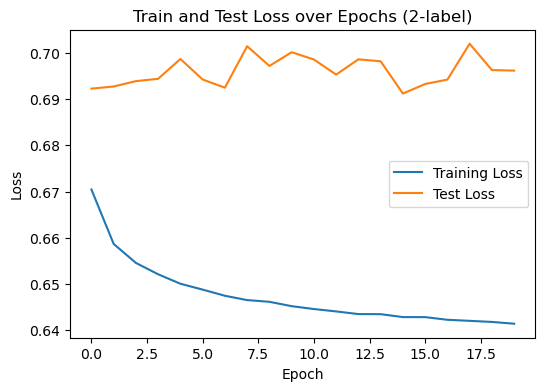

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss over Epochs (2-label)')

plt.show()

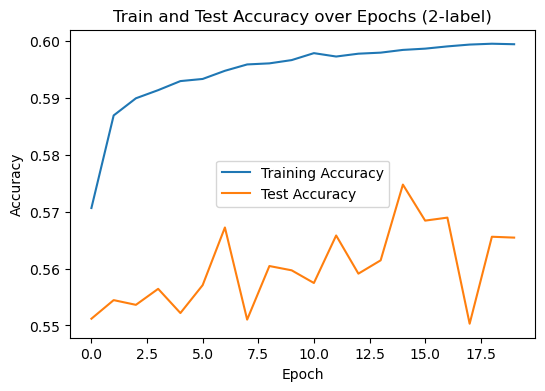

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy over Epochs (2-label)')

plt.show()

In [15]:
import matplotlib.pyplot as plt
train_loss = history2.history['loss']
test_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
test_acc = history2.history['val_accuracy']

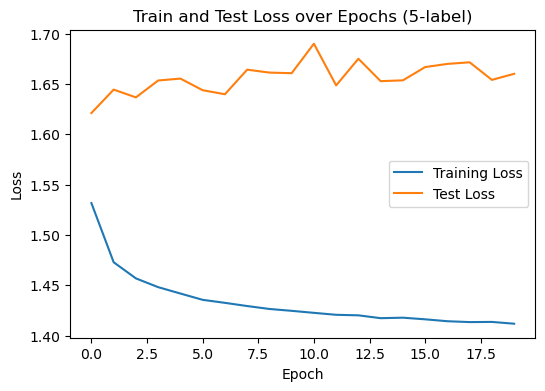

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss over Epochs (5-label)')

plt.show()

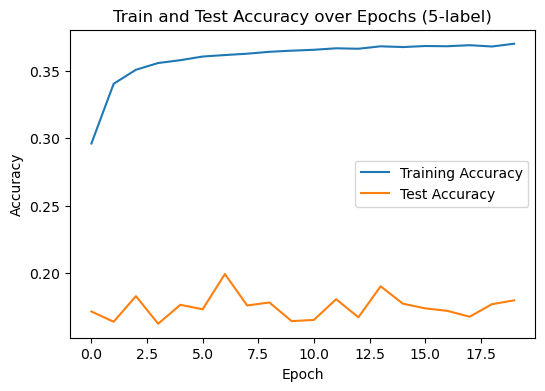

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy over Epochs (5-label)')
plt.show()